In [1]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import noisereduce as nr
import IPython.display
import librosa
import librosa.display
from IPython.display import display
from Audio_Sentiment_Analysis.utils.vscode_audio import Audio
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from tabulate import tabulate
from sklearn import preprocessing

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/extracted_features_iemocap.csv"
DENOISED_EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/denoised_extracted_features_iemocap.csv"

plt.rcParams['figure.dpi'] = 300

In [2]:
def get_metrics(y_labels, y_pred, folds_size, ticks, show_cm=True):
    accs = []
    f1s = []
    pres = []
    recs = []
    mccs = []
    i = 0
    for f_i in range(5):
        acc = round(metrics.accuracy_score(y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]]) * 100, 2)
        f1 = round(metrics.f1_score(y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]], average='macro') * 100, 2)
        pre = round(metrics.precision_score(y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]], average='macro') * 100, 2)
        rec = round(metrics.recall_score(y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]], average='macro') * 100, 2)
        mcc = round(metrics.matthews_corrcoef(y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]]), 2)
        print(f"Accuracy for fold {f_i}: {acc}%")
        i += folds_size[f_i]
        accs.append(acc)
        f1s.append(f1)
        pres.append(pre)
        recs.append(rec)
        mccs.append(mcc)
    
    mean_acc = f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}+-{round(np.std(accs), 2)}"
    mean_f1 = f"{round(metrics.f1_score(y_labels, y_pred, average='macro') * 100, 2)}+-{round(np.std(f1s), 2)}"
    mean_pre = f"{round(metrics.precision_score(y_labels, y_pred, average='macro') * 100, 2)}+-{round(np.std(pres), 2)}"
    mean_rec = f"{round(metrics.recall_score(y_labels, y_pred, average='macro') * 100, 2)}+-{round(np.std(recs), 2)}"
    mean_mcc = f"{round(metrics.matthews_corrcoef(y_labels, y_pred), 2)}+-{round(np.std(mccs), 2)}"

    table = [
        ["Accuracy", mean_acc],
        ["F1 score macro", mean_f1],
        ["Precision", mean_pre],
        ["Recall", mean_rec],
        ["Matthews corrcoef", mean_mcc],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))

    if show_cm:
        cm = metrics.confusion_matrix(y_labels, y_pred)
        plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()

    return [x[1] for x in table]

def categorical_cross_validation(df, get_new_model, used_labels="Angry, Happy+Excited, Sad, Neutral", cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    X = df.iloc[:,8:]
    y = df.iloc[:,4:5]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        folds_size.append(len(y_test))
        
        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "))

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=3)

# Reducing Signal Noise

Sample Rate: 16000 Hz


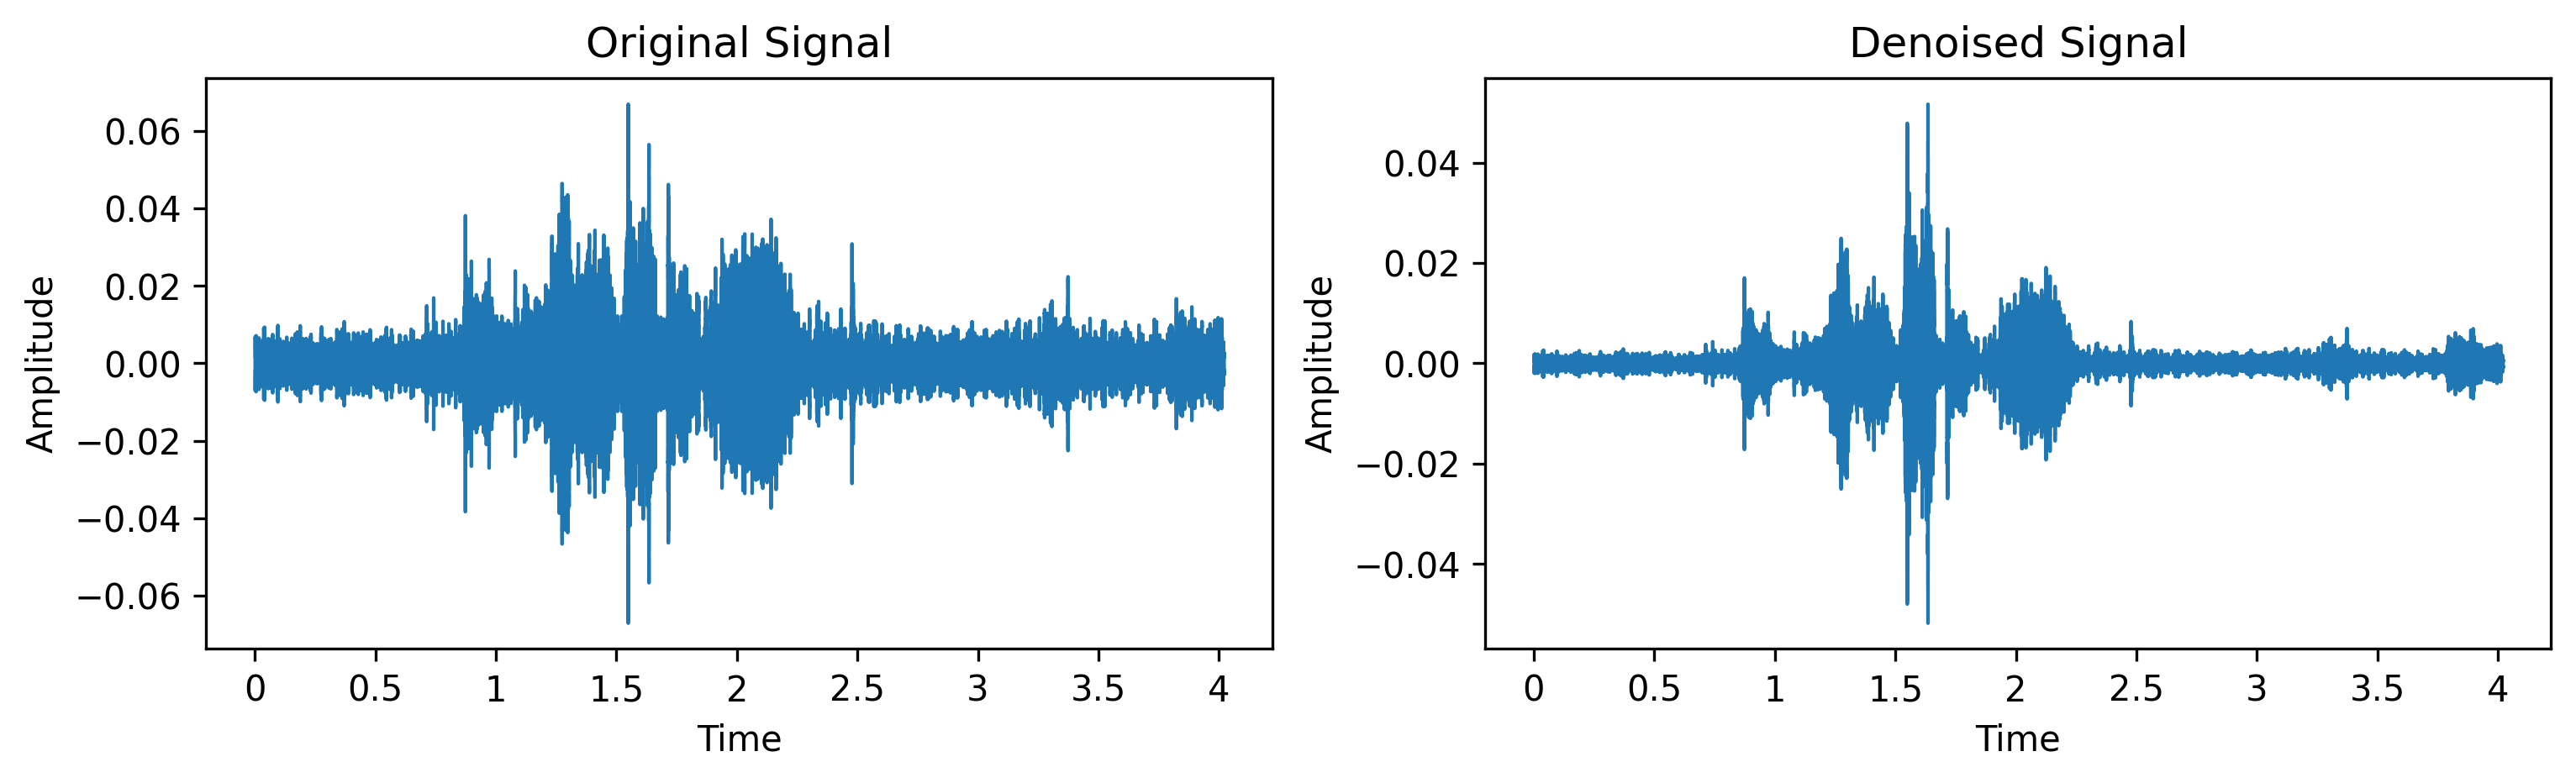

Original Signal - 5 seconds


Denoised Signal - 5 seconds


In [33]:
audio_file_test = AUDIO_DIR+'/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M008.wav'
y, sr = librosa.load(audio_file_test, sr=None)
print(f"Sample Rate: {sr} Hz")

grid = plt.GridSpec(1, 2, wspace=.2, hspace=.1)
plt.figure(figsize=(12, 3))

plt.subplot(grid[0, 0]).set_title("Original Signal")
librosa.display.waveshow(y, sr=sr, ax=plt.subplot(grid[0, 0]))
plt.subplot(grid[0, 0]).set_ylabel("Amplitude")

reduced_noise_y = nr.reduce_noise(y=y, sr=sr, n_fft=2048, hop_length=512, prop_decrease=.75, time_constant_s=1)
librosa.display.waveshow(reduced_noise_y, sr=sr, ax=plt.subplot(grid[0, 1]))
plt.subplot(grid[0, 1]).set_title("Denoised Signal")
plt.subplot(grid[0, 1]).set_ylabel("Amplitude")

plt.show()

print("Original Signal - 5 seconds")
display(Audio(y, sr))

print("Denoised Signal - 5 seconds")
display(Audio(reduced_noise_y, sr))

# Testing on IEMOCAP with Original Signals

Accuracy for fold 0: 58.99%
Accuracy for fold 1: 58.32%
Accuracy for fold 2: 61.75%
Accuracy for fold 3: 59.58%
Accuracy for fold 4: 59.95%

Metric             Value
-----------------  -----------
Accuracy           59.72+-1.16
F1 score macro     60.59+-1.22
Precision          61.69+-1.16
Recall             60.12+-1.38
Matthews corrcoef  0.45+-0.02


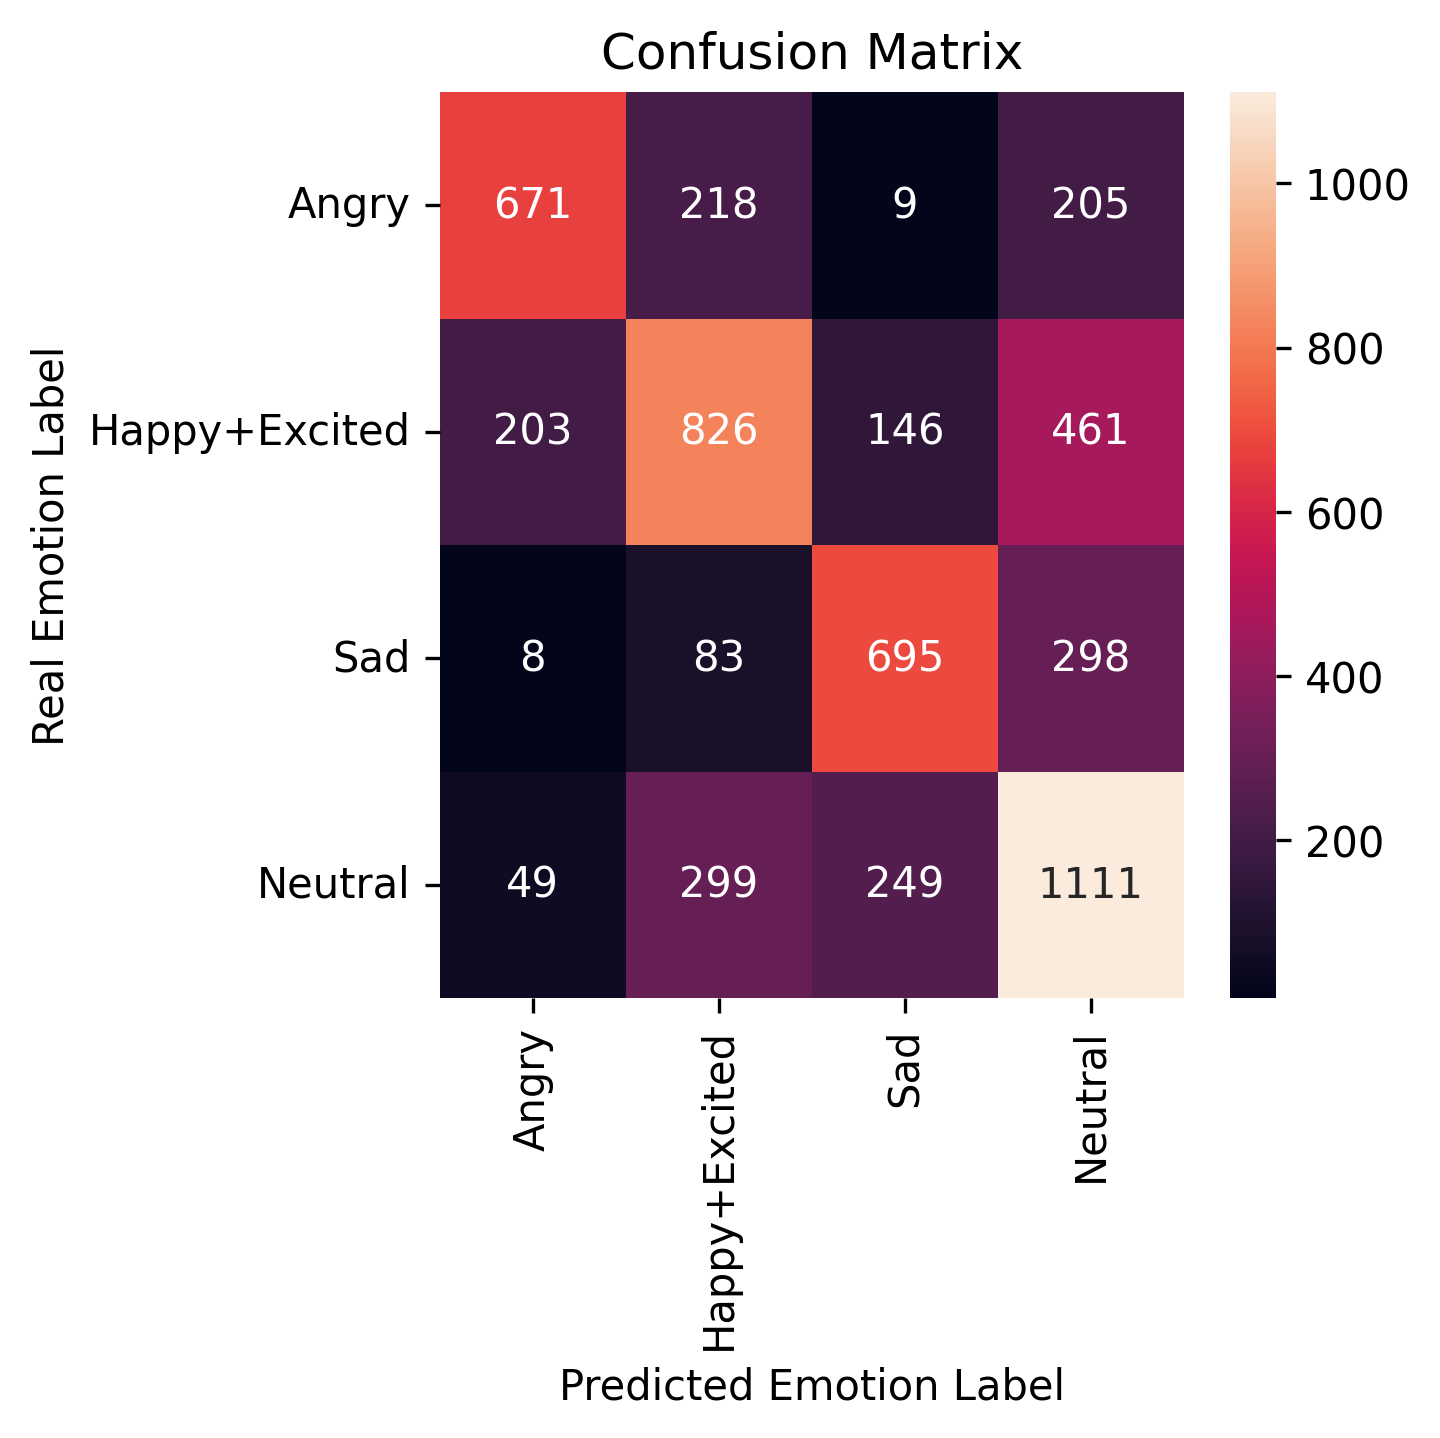

In [19]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

categorical_cross_validation(df, get_new_model)

# Testing on IEMOCAP with Denoised Signals

Accuracy for fold 0: 54.56%
Accuracy for fold 1: 54.7%
Accuracy for fold 2: 56.96%
Accuracy for fold 3: 55.15%
Accuracy for fold 4: 57.78%

Metric             Value
-----------------  -----------
Accuracy           55.83+-1.3
F1 score macro     56.42+-1.27
Precision          57.65+-1.12
Recall             55.97+-1.37
Matthews corrcoef  0.4+-0.02


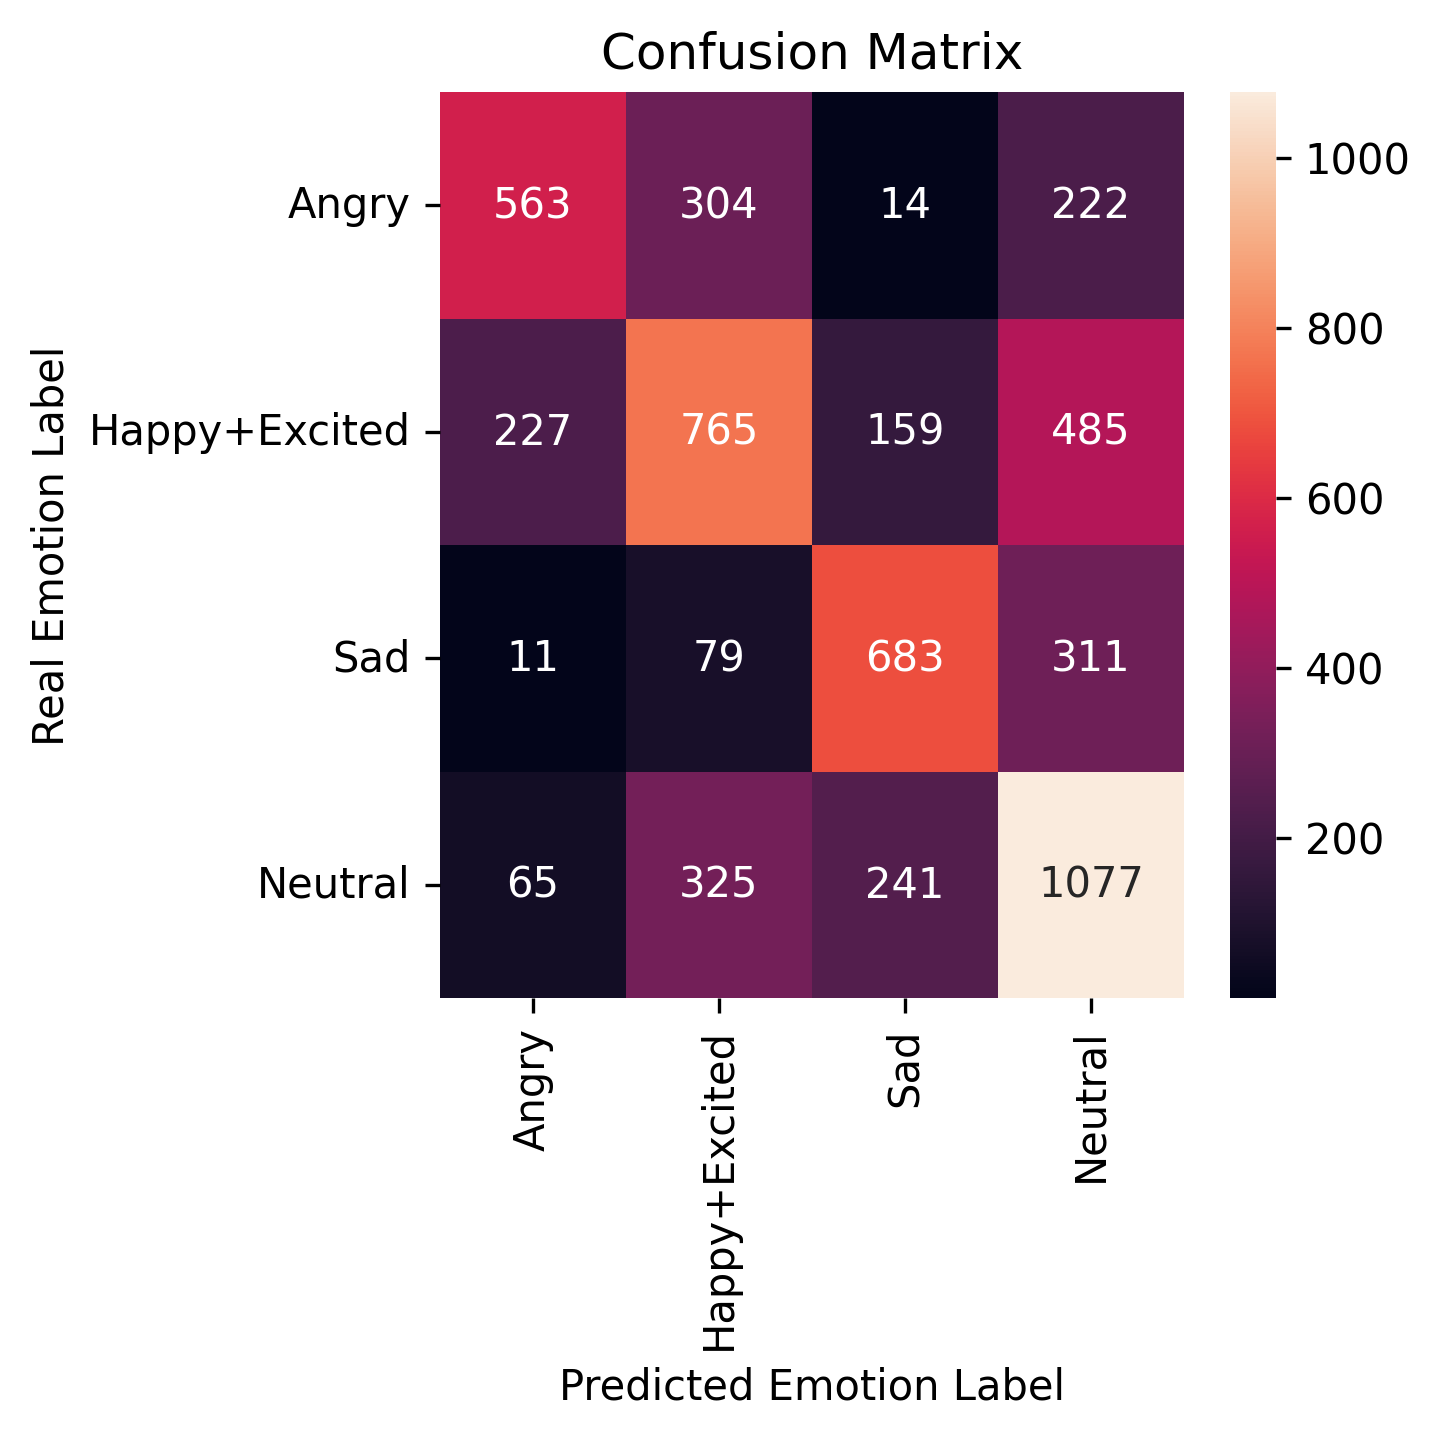

In [20]:
df = pd.read_csv(DENOISED_EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

categorical_cross_validation(df, get_new_model)